# Example 2 (Convolutional Neural Network)

Our first neural network

Do not forget: Runtime -> Change Runtime Type -> Python3 and GPU

If you want to start locally check this [link](https://pytorch.org/get-started/locally/).

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define model

We have three layers (2 convolutional and one fully connected).

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Loading data

We use `DataLoader` and `DataSet` torch util classes.

In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 28488360.25it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 441910.27it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143739.94it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 7144896.88it/s]                            
8192it [00:00, 181352.33it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


# Training and testing loops

Boilerplate code for training and testing (almost never changes).

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# Final parameter tuning and training

In [0]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

# Test before training

test(model, device, test_loader)

for epoch in range(1, 3 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(),"mnist.pt")


Test set: Average loss: 2.3073, Accuracy: 828/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308808
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.158588
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.157247
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067238
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.116226

Test set: Average loss: 0.0655, Accuracy: 9788/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.030749
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.046207
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.067795
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.046699
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.037587

Test set: Average loss: 0.0411, Accuracy: 9868/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.043954
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.029087
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.037714
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.036624
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.088986

Test set: Average loss: 0.0351, Accuracy: 9883/10000 (99%)



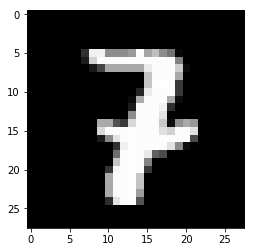

In [0]:
import matplotlib.pyplot as plt

test_image = test_loader.dataset.data[3848]
plt.imshow(test_image, cmap='gray')


In [0]:
out = model(test_image.view(1, 1, 28, 28).float().cuda())
out

tensor([[-1289.5420,  -977.0296,  -381.9371,  -552.9052, -1074.6564, -1673.6279,
         -1843.1631,     0.0000,  -712.5349, -1335.9536]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [0]:
out.argmax(dim=1)

tensor([7], device='cuda:0')

In [0]:
import torchvision
dir(torchvision.models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'Inception3',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'video',
 'wide_resnet101_2',
 'wide_resnet50_2']